# Config:
|sl no|config|mse|mae|r2|
|-----|------|---|---|--|
|1|in_channels-3,num_classes-1,learning_rate-0.0001,batch_size-16,num_epochs-40,n_accumulate-1,competition-FYP Depth Estimation,model_name-Unet scratch,min_lr-1e-06,T_max-500,T_0-100,optimizer-Adam-default,criterion-MSELoss,img-size-(128, 256, 3),depth-map-size-(128, 256, 1),lr scheduler-False,scheduler-CosineAnnealingWarmRestarts||||

In [1]:
!pip install -q segmentation-models-pytorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import torch.utils.data.sampler as sampler

import os
import fnmatch
import numpy as np
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [3]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torchvision.transforms import Resize
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torch.optim import lr_scheduler

# import timm


from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import time
import json
# from albumentations.pytorch import ToTensor


# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL
b_ = Fore.BLUE

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Hyperparameters
cfg = {
    "in_channels" :3,
    "num_classes": 1,
    "learning_rate" : 0.001,
    "batch_size" : 8,
    "num_epochs" : 40,
    "n_accumulate": 1,
    "competition": "FYP Depth Estimation",
    "model_name": "UnetResNext50_imgnet",
    "min_lr": 1e-6,
    "T_max": 500,
    "T_0": 50
}

cfg["learning_rate"] = 1e-3
cfg["optimizer"] = "Adam-default"
cfg["criterion"] = "MSELoss"
cfg["img-size"] = (128, 256, 3)
cfg["depth-map-size"] = (128, 256, 1)
cfg["batch_size"] = 16
cfg["lr scheduler"] = True
cfg["scheduler"] = "CosineAnnealingWarmRestarts" # CosineAnnealingWarmRestarts
cfg["model_dir"] = cfg["model_name"]+"_weights"

# albumentations config
cfg["height"], cfg["width"] = 256,256
cfg["scale"]=(0.08, 1.0)
cfg["ratio"]=(0.75, 1.3333333333333333)
cfg["interpolation"]=1
cfg["w2h_ratio"] = 0.5
cfg["min_max_height"] = (150, 250)
CONFIG = cfg
    
with open("config.json", "w") as outfile:
    json.dump(cfg, outfile)
    

In [5]:
# Import Config
pd.set_option('display.max_colwidth', None)
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model directory
os.makedirs(cfg["model_dir"])

# Seeding for reproducibility
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [6]:
cfg

{'in_channels': 3,
 'num_classes': 1,
 'learning_rate': 0.001,
 'batch_size': 16,
 'num_epochs': 40,
 'n_accumulate': 1,
 'competition': 'FYP Depth Estimation',
 'model_name': 'UnetResNext50_imgnet',
 'min_lr': 1e-06,
 'T_max': 500,
 'T_0': 50,
 'optimizer': 'Adam-default',
 'criterion': 'MSELoss',
 'img-size': (128, 256, 3),
 'depth-map-size': (128, 256, 1),
 'lr scheduler': True,
 'scheduler': 'CosineAnnealingWarmRestarts',
 'model_dir': 'UnetResNext50_imgnet_weights',
 'height': 256,
 'width': 256,
 'scale': (0.08, 1.0),
 'ratio': (0.75, 1.3333333333333333),
 'interpolation': 1,
 'w2h_ratio': 0.5,
 'min_max_height': (150, 250)}

In [7]:
content = ""
for i in cfg.keys():
    content += i+"-"+str(cfg[i])+","
content

'in_channels-3,num_classes-1,learning_rate-0.001,batch_size-16,num_epochs-40,n_accumulate-1,competition-FYP Depth Estimation,model_name-UnetResNext50_imgnet,min_lr-1e-06,T_max-500,T_0-50,optimizer-Adam-default,criterion-MSELoss,img-size-(128, 256, 3),depth-map-size-(128, 256, 1),lr scheduler-True,scheduler-CosineAnnealingWarmRestarts,model_dir-UnetResNext50_imgnet_weights,height-256,width-256,scale-(0.08, 1.0),ratio-(0.75, 1.3333333333333333),interpolation-1,w2h_ratio-0.5,min_max_height-(150, 250),'

# wandb

In [8]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')
# wandb.init(project="PogChamp2 Baseline")
run = wandb.init(project=CONFIG['competition'], 
                 config=CONFIG,
                 job_type='Train',
                 tags=['depth estimation', CONFIG['model_name']],
                 anonymous='must',
                 name = "UnetDensenet121_imgnet (main: 2)",
                 notes = "minor fix: model updated to UnetDensenet121, augmentatoin(albu) added")
       
# wandb.finish()

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# dataset

In [9]:
class CityScapes(Dataset):
    def __init__(self, root,transform=None, train=True):
        self.train = train
        self.root = os.path.expanduser(root)
        self.transform = transform

        # read the data file
        if train:
            self.data_path = root + '/train'
        else:
            self.data_path = root + '/val'

        # calculate data length
        self.data_len = len(fnmatch.filter(os.listdir(self.data_path + '/image'), '*.npy'))

    def __getitem__(self, index):
        # load data from the pre-processed npy files
#         image = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/image/{:d}.npy'.format(index)), -1, 0))
# #         semantic = torch.from_numpy(np.load(self.data_path + '/label/{:d}.npy'.format(index)))
#         depth = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/depth/{:d}.npy'.format(index)), -1, 0))
#         print(self.data_path + '/image/{:d}.npy'.format(index))
        image = np.load(self.data_path + '/image/{:d}.npy'.format(index))
#         print("img shape ",str(image.shape))
#         semantic = torch.from_numpy(np.load(self.data_path + '/label/{:d}.npy'.format(index)))
        depth = np.load(self.data_path + '/depth/{:d}.npy'.format(index))
        
#         print(depth.shape)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=depth)
            image = transformed["image"]
            depth = transformed["mask"]

            if depth.shape[-1] == 1:
                depth = depth.permute(2,0,1)
        
            
        
        return image.float(), depth.float()

    def __len__(self):
        return self.data_len

In [10]:
train_transform = A.Compose(
    [
#         A.Resize(256, 256, p=1),
#         A.HorizontalFlip(p=1.0),
#         A.RandomCrop(224, 224, p=0.3),
#         A.RandomSizedCrop(cfg["min_max_height"], cfg["height"], cfg["width"], cfg["w2h_ratio"], cfg["interpolation"], p=1), 
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
#         A.Resize(256, 256, p=1.0),
        ToTensorV2(),
    ]
)

In [11]:
dataset_path = '../input/cityscapes-depth-and-segmentation/data'
train_set = CityScapes(root=dataset_path,transform=train_transform, train=True)
test_set = CityScapes(root=dataset_path,transform=test_transform, train=False)

In [12]:
img, depth = train_set[0]
img.shape, depth.shape

(torch.Size([3, 128, 256]), torch.Size([1, 128, 256]))

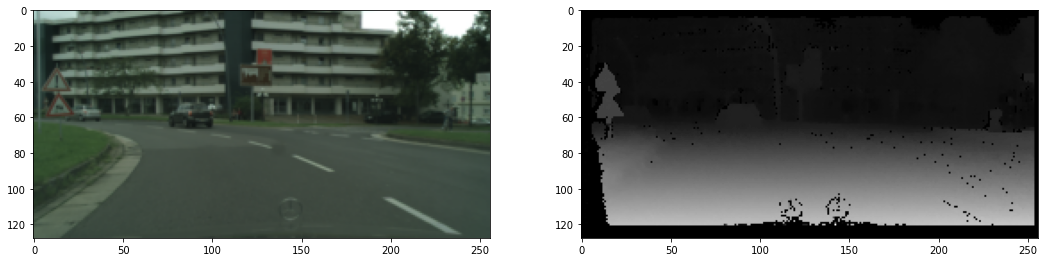

In [13]:
img_np = img.permute(1,2,0).detach().numpy()

depth_np = depth.permute(1,2,0).detach().numpy()
plt.figure(figsize=(18,18))
plt.subplot(1,2,1)
plt.imshow(img_np)

plt.subplot(1,2,2)
plt.imshow(depth_np,cmap="gray")

In [14]:
np.unique(depth),depth.min(),depth.max()

(array([0.0000000e+00, 1.5259022e-05, 4.0131230e-03, ..., 3.6717784e-01,
        3.7523460e-01, 4.7335011e-01], dtype=float32),
 tensor(0.),
 tensor(0.4734))

In [15]:
def props(img,show_uniques=True):
    print("Shape :",img.shape,"Maximum :",img.max(),"Minimum :",img.min(),"Data Type :",img.dtype)
    if show_uniques:
        print("Uniques :",np.unique(img))
        
props(depth,False)

Shape : torch.Size([1, 128, 256]) Maximum : tensor(0.4734) Minimum : tensor(0.) Data Type : torch.float32


# Unet mode def

In [16]:
# !wget http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth

In [17]:
train_on_gpu = torch.cuda.is_available()
model = smp.Unet(
                encoder_name="densenet121",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights='imagenet', #'imagenet' or None,     # use `imagenet` pre-trained weights for encoder initialization
                in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=1,                      # model output channels (number of classes in your dataset)
                activation='sigmoid',
    )

if train_on_gpu:
    model.cuda()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/hub/checkpoints/densenet121-fbdb23505.pth


  0%|          | 0.00/30.9M [00:00<?, ?B/s]

In [18]:
# train_on_gpu = torch.cuda.is_available()
# model1 = UNet_depth(n_channels=cfg["in_channels"], n_classes=cfg["num_classes"]).float()
# if train_on_gpu:
#     model1.cuda()

In [19]:
# model(torch.randn(2,3,256,256).cuda()).shape

In [20]:
model(torch.randn(2,3,256,256).cuda()).shape

torch.Size([2, 1, 256, 256])

In [21]:
# batch_size = 8
train_loader = torch.utils.data.DataLoader(
               dataset=train_set,
               batch_size=cfg["batch_size"],
               shuffle=False,
               num_workers=2)

test_loader = torch.utils.data.DataLoader(
              dataset=test_set,
              batch_size=cfg["batch_size"],
              shuffle=False,
              num_workers=2)


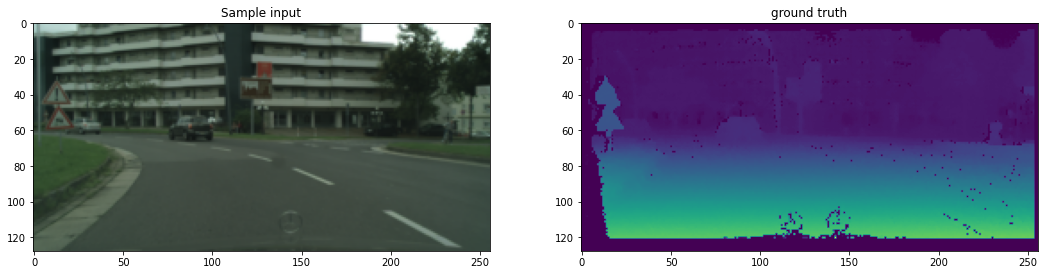

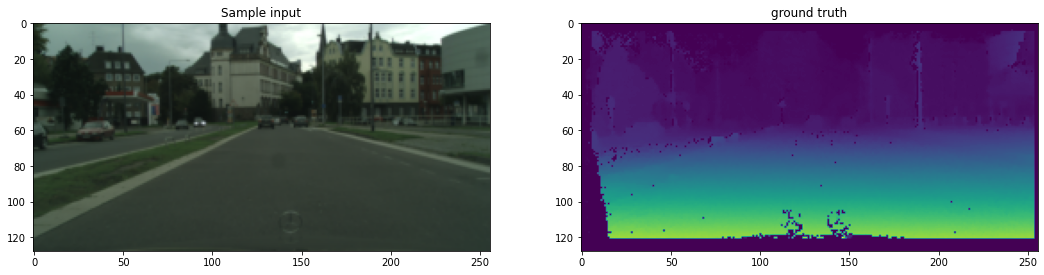

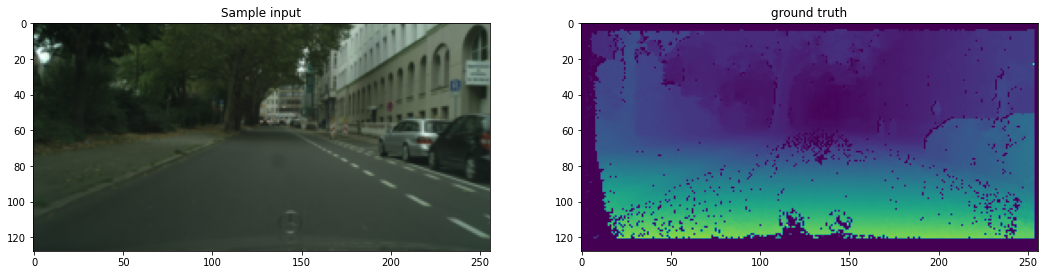

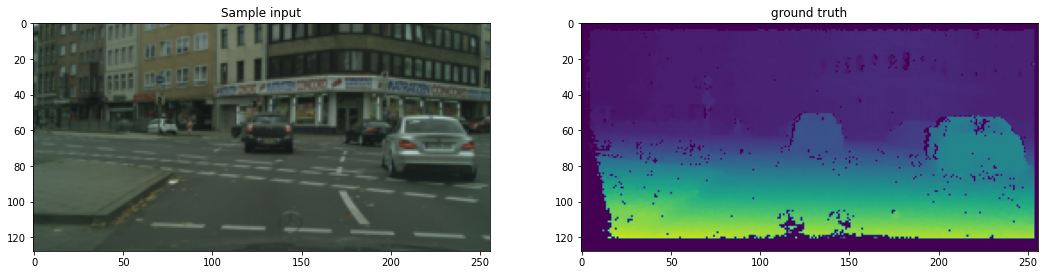

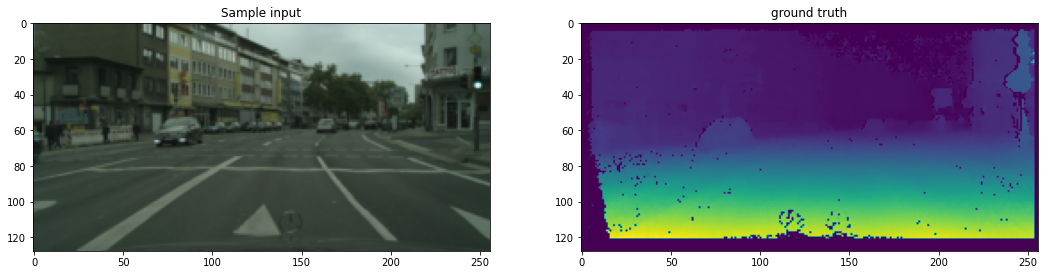

In [22]:
ip_img = next(iter(train_loader))[0][0:5]
ip_deph = next(iter(train_loader))[1][0:5]

for i, j in zip(ip_img,ip_deph):
    plt.figure(figsize=(18,18))
    plt.subplot(1,2,1)
    plt.imshow(i.permute(1, 2, 0))
    plt.title("Sample input")
    
    plt.subplot(1,2,2)
    plt.imshow(j.permute(1, 2, 0))
    plt.title("ground truth")

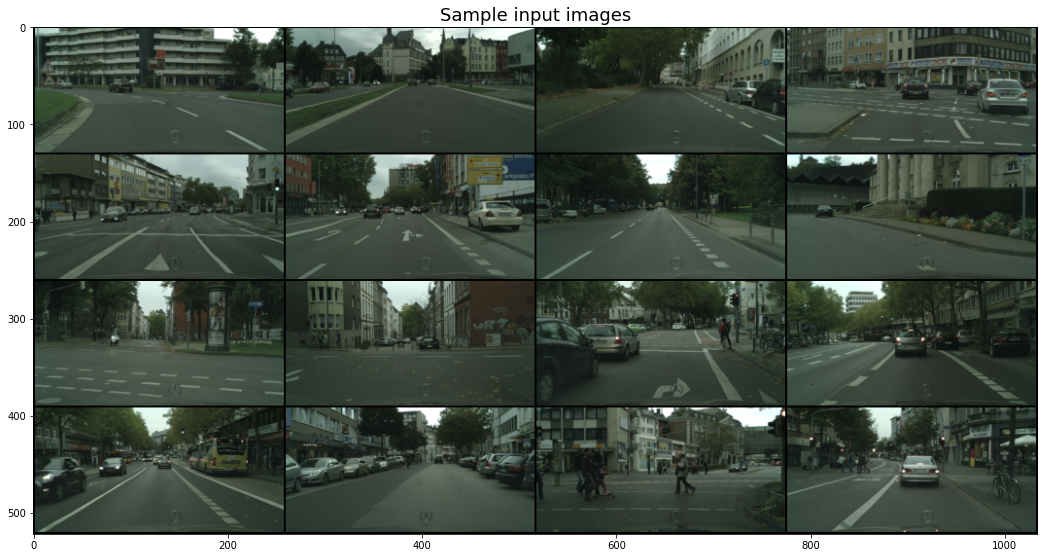

In [23]:
grid_img = torchvision.utils.make_grid(next(iter(train_loader))[0], nrow=4)
plt.figure(figsize=(18,18))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Sample input images",fontsize=18);

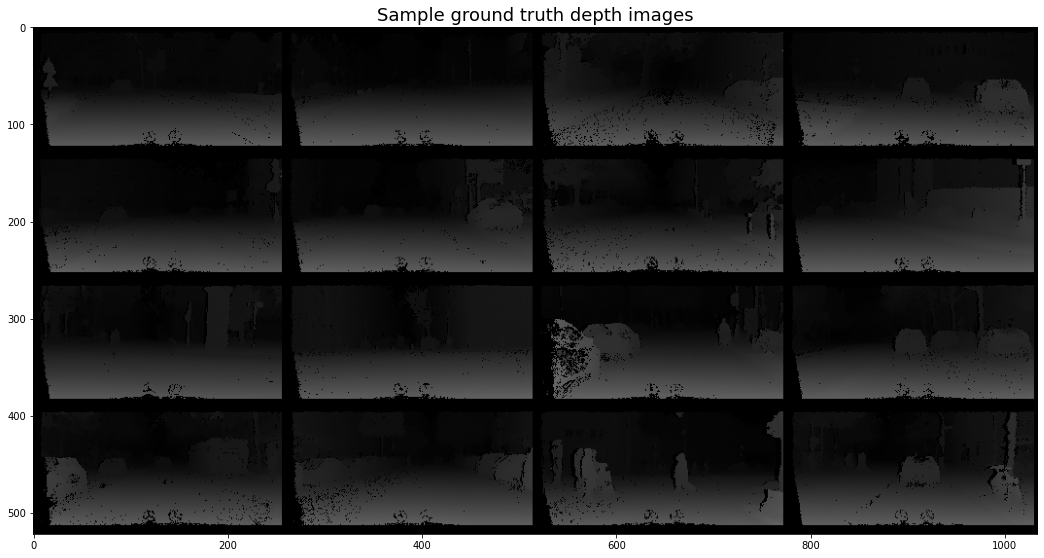

In [24]:
grid_dph = torchvision.utils.make_grid(next(iter(train_loader))[1], nrow=4)
plt.figure(figsize=(18,18))
plt.imshow(grid_dph.permute(1, 2, 0))
plt.title("Sample ground truth depth images",fontsize=18);

In [25]:
def save_model(epoch, model, model_file):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_file)

In [26]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=cfg["learning_rate"])
scheduler = fetch_scheduler(optimizer)
scaler = torch.cuda.amp.GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.4, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-7, eps=1e-08, verbose=True)

In [28]:
# from tqdm import tqdm
# # Train Network
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# total_epoch = 10
# for epoch in range(10):
#     print(f"============ starting epoch [{epoch+1}/{total_epoch}] ============")
#     running_loss = 0.0
    
    
#     for i, (data, targets) in enumerate(tqdm(train_loader)):
#         # Get data to cuda if possible
#         data = data.to(device=device)
#         targets = targets.to(device=device)
        
#         # forward
#         scores = model(data)
#         loss = criterion(scores, targets)  # CrossEntropyLoss accepts prediction in the shape of (64,10) and target is 64 [not sure]

#         # backward
#         optimizer.zero_grad()
#         loss.backward()

#         # gradient descent or adam step
#         optimizer.step()
        
#         running_loss += loss.item()

#         if i % 4 == 0:    # print every 4 mini-batches
# #             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#             wandb.log({'epoch': epoch+1, 'loss': running_loss/2000})
#             running_loss = 0.0
        
#     print(f"total loss {running_loss}")
# #     print('Finished Training')
    
# #     save_model(epoch,model,f"cnn_adam_e{epoch}.pth")

In [29]:
# https://www.kaggle.com/code/debarshichanda/pytorch-w-b-birdclef-22-starter
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, scaler=None):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (data, targets) in bar:
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        batch_size = data.size(0)
        
        if scaler is not None:
            with torch.cuda.amp.autocast(): # remove this line and put the next three line in the for loop
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss = loss / cfg['n_accumulate']
        else:
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss = loss / cfg['n_accumulate']
            
        if scaler is not None:
            scaler.scale(loss).backward()
        else:
            loss.backward() #scaler.scale(loss).backward() # replace this if not mixed precission with this `loss.backward()`
    
        if (step + 1) % cfg['n_accumulate'] == 0:
            
            if scaler is not None:
                scaler.step(optimizer)
            else:
                optimizer.step() # scaler.step(optimizer) # optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad() # 

            if scheduler is not None:
                scheduler.step() #scaler.step(scheduler) # set it to this if the scheduler is none scheduler.step()
        
        if scaler is not None:
            scaler.update() # add this if mixed precission is required
        else:
            pass
#         running_loss += (loss.item() * batch_size)
        running_loss += loss.item()
#         epoch_loss = running_loss / dataset_size
        dataset_size += batch_size
        
        epoch_loss = running_loss / len(dataloader)
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [31]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    LABELS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (data, targets) in bar:
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        batch_size = data.size(0)

        outputs = model(data)
#         _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(outputs.view(-1).cpu().detach().numpy())
        LABELS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    LABELS = np.concatenate(LABELS)
    PREDS = np.concatenate(PREDS)
    val_mae = mean_absolute_error(LABELS, PREDS)
    val_mse = mean_squared_error(LABELS, PREDS)
    val_r2 = r2_score(LABELS, PREDS)

    print("val_mae", val_mae)
    print("val_mse", val_mse)
    print("val_r2", val_r2)
    
    
    gc.collect()
    
    return epoch_loss, val_mae, val_mse,val_r2

# train:

In [32]:
# https://www.kaggle.com/code/debarshichanda/pytorch-w-b-birdclef-22-starter
def run_training(model, train_loader, valid_loader, optimizer, device, num_epochs,scaler=None, model_dir=None, scheduler=None):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_mae = float('inf')
    best_epoch_mse = float('inf')
    best_epoch_r2 = float('inf')
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        PATH = ""
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=device, epoch=epoch, scaler= scaler)
        
        val_epoch_loss, val_epoch_mae, val_epoch_mse, val_epoch_r2 = valid_one_epoch(model, valid_loader, 
                                                       device=device, 
                                                       epoch=epoch)
    
        history['Train_Loss'].append(train_epoch_loss)
        history['Valid_Loss'].append(val_epoch_loss)
        history['Valid_mae'].append(val_epoch_mae)
        history['Valid_mse'].append(val_epoch_mse)
        history['Valid_r2'].append(val_epoch_r2)

        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid mae": val_epoch_mae})
        wandb.log({"Valid mse": val_epoch_mse})
        wandb.log({"Valid r2": val_epoch_r2})

        
        # deep copy the model
        if val_epoch_mae <= best_epoch_mae and val_epoch_mse <= best_epoch_mse:
            print(f"{b_}Validation mse Improved ({best_epoch_mse} ---> {val_epoch_mse})")
            best_epoch_mse = val_epoch_mse
            run.summary["Best mse Score"] = best_epoch_mse
            
            
            print(f"{b_}Validation mae Improved ({best_epoch_mae} ---> {val_epoch_mae})")
            best_epoch_mae = val_epoch_mae
            run.summary["Best mae Score"] = best_epoch_mae
            
            best_model_wts = copy.deepcopy(model.state_dict())
            
            PATH = cfg["model_dir"]+ "/" + "epoch{:.0f}_mae{:.4f}_mse{:.4f}.pth".format(epoch, best_epoch_mae,best_epoch_mse)
            
            save_model(epoch, model, PATH)
            history['model_path'].append(PATH)
#             print(f"Model Saved{sr_}")
        
        # deep copy the model
        elif val_epoch_mae <= best_epoch_mae and val_epoch_mse <= best_epoch_mse:
            print(f"{b_}Validation mae Improved ({best_epoch_mae} ---> {val_epoch_mae})")
            best_epoch_mae = val_epoch_mae
            run.summary["Best mae Score"] = best_epoch_mae
            best_model_wts = copy.deepcopy(model.state_dict())
#             PATH = "F1{:.4f}_epoch{:.0f}.pth".format(best_epoch_mae, epoch)
            PATH = cfg["model_dir"]+ "/" + "epoch{:.0f}_mae{:.4f}_mse{:.4f}.pth".format(epoch, best_epoch_mae,best_epoch_mse)
            
            save_model(epoch, model, PATH)
            history['model_path'].append(PATH)
        
#             print(f"Model Saved{sr_}")
            
            
        # deep copy the model
        elif val_epoch_mse <= best_epoch_mse and val_epoch_mae <= best_epoch_mae:
            print(f"{b_}Validation mse Improved ({best_epoch_mse} ---> {val_epoch_mse})")
            best_epoch_mse = val_epochmse
            run.summary["Best mse Score"] = best_epoch_mse
            best_model_wts = copy.deepcopy(model.state_dict())
#             PATH = "F1{:.4f}_epoch{:.0f}.pth".format(best_epoch_mse, epoch)
            PATH = cfg["model_dir"]+ "/" + "epoch{:.0f}_mae{:.4f}_mse{:.4f}.pth".format(epoch, best_epoch_mae,best_epoch_mse)
            
            save_model(epoch, model, PATH)
            history['model_path'].append(PATH)
#             torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
#             print(f"Model Saved{sr_}")
        
        else:
            history['model_path'].append("not_saved")
        
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best mae: {:.4f}  || mse {:.4f} || r2 {:.4f} ||".format(best_epoch_mae, best_epoch_mse, max(history['Valid_r2'])))
    print(f"epoch: {history['Valid_r2'].index(max(history['Valid_r2']))}")
#     print()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# Metric check:

In [33]:
import copy
from collections import defaultdict
import gc

model, history = run_training(model,train_loader,
                              test_loader, optimizer,
                              device=device,
                              num_epochs=cfg["num_epochs"],#cfg["num_epochs"]
                              model_dir = cfg["model_dir"],
                              scheduler=scheduler,
                              scaler = scaler # scaler 
                              ) # scheduler=scheduler

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 32/32 [00:05<00:00,  6.03it/s, Epoch=1, LR=0.000182, Valid_Loss=0.00493]


val_mae 0.04412432
val_mse 0.004929757
val_r2 0.6159182177074225
Validation mse Improved (inf ---> 0.004929757211357355)
Validation mae Improved (inf ---> 0.04412432014942169)



100%|██████████| 32/32 [00:04<00:00,  6.70it/s, Epoch=2, LR=0.000594, Valid_Loss=0.00387]


val_mae 0.034576632
val_mse 0.0038694828
val_r2 0.6985250797854579
Validation mse Improved (0.004929757211357355 ---> 0.003869482781738043)
Validation mae Improved (0.04412432014942169 ---> 0.03457663208246231)



100%|██████████| 32/32 [00:04<00:00,  6.56it/s, Epoch=3, LR=0.000938, Valid_Loss=0.00374]


val_mae 0.033814203
val_mse 0.0037417095
val_r2 0.7084798220627095
Validation mse Improved (0.003869482781738043 ---> 0.003741709515452385)
Validation mae Improved (0.03457663208246231 ---> 0.0338142029941082)



100%|██████████| 32/32 [00:04<00:00,  6.83it/s, Epoch=4, LR=3.61e-5, Valid_Loss=0.00363]


val_mae 0.0333266
val_mse 0.0036326894
val_r2 0.7169739761903227
Validation mse Improved (0.003741709515452385 ---> 0.0036326893605291843)
Validation mae Improved (0.0338142029941082 ---> 0.03332659974694252)



100%|██████████| 32/32 [00:04<00:00,  6.42it/s, Epoch=5, LR=0.000346, Valid_Loss=0.00397]


val_mae 0.032712426
val_mse 0.0039672437
val_r2 0.6909084949750943



100%|██████████| 32/32 [00:04<00:00,  6.82it/s, Epoch=6, LR=0.000768, Valid_Loss=0.00333]


val_mae 0.030514147
val_mse 0.0033319667
val_r2 0.7404034447653955
Validation mse Improved (0.0036326893605291843 ---> 0.0033319666981697083)
Validation mae Improved (0.03332659974694252 ---> 0.030514147132635117)



100%|██████████| 32/32 [00:04<00:00,  6.91it/s, Epoch=7, LR=0.000996, Valid_Loss=0.00342]


val_mae 0.031815775
val_mse 0.003418595
val_r2 0.7336543375237189



100%|██████████| 32/32 [00:04<00:00,  6.46it/s, Epoch=8, LR=0.000136, Valid_Loss=0.00327]


val_mae 0.030935047
val_mse 0.003272627
val_r2 0.7450267360197169



100%|██████████| 32/32 [00:04<00:00,  6.69it/s, Epoch=9, LR=0.000532, Valid_Loss=0.00314]


val_mae 0.029111234
val_mse 0.0031411278
val_r2 0.7552718823988986
Validation mse Improved (0.0033319666981697083 ---> 0.003141127759590745)
Validation mae Improved (0.030514147132635117 ---> 0.029111234471201897)



100%|██████████| 32/32 [00:04<00:00,  6.92it/s, Epoch=10, LR=0.000905, Valid_Loss=0.00302]


val_mae 0.029545955
val_mse 0.003016868
val_r2 0.7649534267679241



100%|██████████| 32/32 [00:04<00:00,  6.48it/s, Epoch=11, LR=1.67e-5, Valid_Loss=0.00314]


val_mae 0.028729191
val_mse 0.00313501
val_r2 0.7557485650233984
Validation mse Improved (0.003141127759590745 ---> 0.003135009901598096)
Validation mae Improved (0.029111234471201897 ---> 0.028729191049933434)



100%|██████████| 32/32 [00:05<00:00,  6.22it/s, Epoch=12, LR=0.000288, Valid_Loss=0.00327]


val_mae 0.031038731
val_mse 0.003270584
val_r2 0.7451860004120394



100%|██████████| 32/32 [00:04<00:00,  6.76it/s, Epoch=13, LR=0.000713, Valid_Loss=0.00271]


val_mae 0.025281647
val_mse 0.0027123613
val_r2 0.7886777595945271
Validation mse Improved (0.003135009901598096 ---> 0.002712361281737685)
Validation mae Improved (0.028729191049933434 ---> 0.025281647220253944)



100%|██████████| 32/32 [00:04<00:00,  6.45it/s, Epoch=14, LR=0.000984, Valid_Loss=0.00251]


val_mae 0.02448392
val_mse 0.0025078491
val_r2 0.8046114598785196
Validation mse Improved (0.002712361281737685 ---> 0.0025078491307795048)
Validation mae Improved (0.025281647220253944 ---> 0.024483919143676758)



100%|██████████| 32/32 [00:04<00:00,  6.92it/s, Epoch=15, LR=9.64e-5, Valid_Loss=0.0027]


val_mae 0.026113376
val_mse 0.002695518
val_r2 0.7899895273825004



100%|██████████| 32/32 [00:04<00:00,  6.90it/s, Epoch=16, LR=0.000469, Valid_Loss=0.00259]


val_mae 0.025148282
val_mse 0.0025904672
val_r2 0.798174640577096



100%|██████████| 32/32 [00:04<00:00,  6.83it/s, Epoch=17, LR=0.000865, Valid_Loss=0.00261]


val_mae 0.025662117
val_mse 0.002613586
val_r2 0.7963732246376901



100%|██████████| 32/32 [00:04<00:00,  6.66it/s, Epoch=18, LR=4.94e-6, Valid_Loss=0.00255]


val_mae 0.02387063
val_mse 0.0025487074
val_r2 0.801427744565392



100%|██████████| 32/32 [00:05<00:00,  6.08it/s, Epoch=19, LR=0.000233, Valid_Loss=0.00274]


val_mae 0.025415746
val_mse 0.0027379016
val_r2 0.7866877283049317



100%|██████████| 32/32 [00:04<00:00,  6.77it/s, Epoch=20, LR=0.000655, Valid_Loss=0.00258]


val_mae 0.024601823
val_mse 0.0025841657
val_r2 0.7986653194906113



100%|██████████| 32/32 [00:04<00:00,  6.86it/s, Epoch=21, LR=0.000965, Valid_Loss=0.0026]


val_mae 0.024405446
val_mse 0.0025993327
val_r2 0.7974839732467485



100%|██████████| 32/32 [00:04<00:00,  6.46it/s, Epoch=22, LR=6.28e-5, Valid_Loss=0.00271]


val_mae 0.023821639
val_mse 0.0027113422
val_r2 0.7887566126490743



100%|██████████| 32/32 [00:04<00:00,  6.81it/s, Epoch=23, LR=0.000407, Valid_Loss=0.00239]


val_mae 0.024084413
val_mse 0.0023892066
val_r2 0.8138547905868212
Validation mse Improved (0.0025078491307795048 ---> 0.002389206551015377)
Validation mae Improved (0.024483919143676758 ---> 0.024084413424134254)



100%|██████████| 32/32 [00:05<00:00,  5.99it/s, Epoch=24, LR=0.000819, Valid_Loss=0.00223]


val_mae 0.02207098
val_mse 0.0022336312
val_r2 0.8259756608068863
Validation mse Improved (0.002389206551015377 ---> 0.0022336312104016542)
Validation mae Improved (0.024084413424134254 ---> 0.022070979699492455)



100%|██████████| 32/32 [00:04<00:00,  6.67it/s, Epoch=25, LR=0.001, Valid_Loss=0.00222]


val_mae 0.021950431
val_mse 0.0022241608
val_r2 0.8267135961641767
Validation mse Improved (0.0022336312104016542 ---> 0.002224160823971033)
Validation mae Improved (0.022070979699492455 ---> 0.021950431168079376)



100%|██████████| 32/32 [00:04<00:00,  6.81it/s, Epoch=26, LR=0.000182, Valid_Loss=0.00343]


val_mae 0.034423392
val_mse 0.0034304247
val_r2 0.732732660613048



100%|██████████| 32/32 [00:04<00:00,  6.41it/s, Epoch=27, LR=0.000594, Valid_Loss=0.00338]


val_mae 0.03054815
val_mse 0.0033762576
val_r2 0.7369524586946803



100%|██████████| 32/32 [00:04<00:00,  6.90it/s, Epoch=28, LR=0.000938, Valid_Loss=0.00307]


val_mae 0.029398734
val_mse 0.003069702
val_r2 0.7608371467117025



100%|██████████| 32/32 [00:04<00:00,  6.90it/s, Epoch=29, LR=3.61e-5, Valid_Loss=0.00287]


val_mae 0.027480489
val_mse 0.0028717993
val_r2 0.7762553187399711



100%|██████████| 32/32 [00:05<00:00,  6.21it/s, Epoch=30, LR=0.000346, Valid_Loss=0.00285]


val_mae 0.02722592
val_mse 0.0028497765
val_r2 0.7779712341603793



100%|██████████| 32/32 [00:05<00:00,  5.97it/s, Epoch=31, LR=0.000768, Valid_Loss=0.00237]


val_mae 0.023763882
val_mse 0.0023728511
val_r2 0.8151292999525872



100%|██████████| 32/32 [00:04<00:00,  6.83it/s, Epoch=32, LR=0.000996, Valid_Loss=0.00229]


val_mae 0.02424548
val_mse 0.002291211
val_r2 0.8214897036562625



100%|██████████| 32/32 [00:04<00:00,  6.67it/s, Epoch=33, LR=0.000136, Valid_Loss=0.00238]


val_mae 0.024293473
val_mse 0.0023818782
val_r2 0.8144258803720048



100%|██████████| 32/32 [00:04<00:00,  6.68it/s, Epoch=34, LR=0.000532, Valid_Loss=0.00244]


val_mae 0.02314005
val_mse 0.002438287
val_r2 0.8100308490388275



100%|██████████| 32/32 [00:04<00:00,  6.62it/s, Epoch=35, LR=0.000905, Valid_Loss=0.00227]


val_mae 0.023227347
val_mse 0.002269097
val_r2 0.8232128135029148



100%|██████████| 32/32 [00:04<00:00,  6.64it/s, Epoch=36, LR=1.67e-5, Valid_Loss=0.00237]


val_mae 0.022578225
val_mse 0.0023664737
val_r2 0.8156257971005169



100%|██████████| 32/32 [00:04<00:00,  6.68it/s, Epoch=37, LR=0.000288, Valid_Loss=0.00217]


val_mae 0.022156898
val_mse 0.0021661252
val_r2 0.8312351796208769



100%|██████████| 32/32 [00:06<00:00,  4.93it/s, Epoch=38, LR=0.000713, Valid_Loss=0.00222]


val_mae 0.022556564
val_mse 0.0022169955
val_r2 0.8272719223423345



100%|██████████| 32/32 [00:04<00:00,  6.59it/s, Epoch=39, LR=0.000984, Valid_Loss=0.00223]


val_mae 0.022907592
val_mse 0.0022311902
val_r2 0.8261659852700212



100%|██████████| 32/32 [00:04<00:00,  6.78it/s, Epoch=40, LR=9.64e-5, Valid_Loss=0.00236]


val_mae 0.022862831
val_mse 0.0023569686
val_r2 0.8163664841868217

Training complete in 0h 51m 58s
Best mae: 0.0220  || mse 0.0022 || r2 0.8312 ||
epoch: 36


In [34]:
len(os.listdir("../input/cityscapes-depth-and-segmentation/data/train/image"))

2975

In [35]:
history.keys()

dict_keys(['Train_Loss', 'Valid_Loss', 'Valid_mae', 'Valid_mse', 'Valid_r2', 'model_path'])

In [36]:
results_df = pd.DataFrame(history)

results_df.to_csv("results.csv")

results_df.head()

,Train_Loss,Valid_Loss,Valid_mae,Valid_mse,Valid_r2,model_path
0,0.015052,0.004930,0.044124,0.004930,0.615918,UnetResNext50_imgnet_weights/epoch1_mae0.0441_mse0.0049.pth
1,0.003116,0.003869,0.034577,0.003869,0.698525,UnetResNext50_imgnet_weights/epoch2_mae0.0346_mse0.0039.pth
2,0.002849,0.003742,0.033814,0.003742,0.708480,UnetResNext50_imgnet_weights/epoch3_mae0.0338_mse0.0037.pth
3,0.002736,0.003633,0.033327,0.003633,0.716974,UnetResNext50_imgnet_weights/epoch4_mae0.0333_mse0.0036.pth
4,0.002683,0.003967,0.032712,0.003967,0.690908,not_saved


# Inference:

In [37]:
best_model_path = history["model_path"][-1]
print("model path: ", best_model_path)
train_on_gpu = torch.cuda.is_available()
Model = smp.Unet(
                encoder_name="densenet121",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights=None,#'imagenet',#'imagenet' or None,     # use `imagenet` pre-trained weights for encoder initialization
                in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=1,                      # model output channels (number of classes in your dataset)
                activation='sigmoid',
    )
if train_on_gpu:
    Model.cuda()
    
Model.load_state_dict(torch.load(best_model_path)['model_state_dict'])

model path:  not_saved


FileNotFoundError: [Errno 2] No such file or directory: 'not_saved'

In [ ]:
def plot_infr(img,pred_img,gt_img,num):
    plt.figure(figsize=(18,18))
    plt.subplot(1,3,1)
    plt.imshow(img)
    
    plt.subplot(1,3,2)
    plt.imshow(pred_img)
    
    plt.subplot(1,3,3)
    plt.imshow(gt_img)
    
    fname = "image"+str(num)+".png"
    plt.savefig(fname)

In [ ]:
for i in range(3):
    pic,dep = test_set[i]
    pred = Model(pic.unsqueeze(dim=0).cuda()).squeeze(dim=0).reshape((128, 256)).cpu().detach().numpy()
    gt = dep.permute(1,2,0).detach().numpy()
    pic = pic.permute(1,2,0).detach().numpy()
#     print(pic.shape,gt.shape,pred.shape)
#     break
    plot_infr(pic,pred,gt,i)

In [ ]:
import glob
for i in glob.glob("./*.png"):
    wandb.save(i)
#     print(i)

In [ ]:
wandb.save("./config.json")
wandb.save("results.csv")